# Introduction

The main function of this module is to convert recored peak intensities to particle sizes and create a [sizedistribution instance](./sizedistribution.ipynb).

# Imports

In [1]:
from atmPy.aerosols.instruments.POPS import peaks,calibration
import matplotlib.pylab as plt
from atmPy.tools import plt_tools
import numpy as np
import pathlib as pl

In [2]:
# %matplotlib inline
# plt_tools.setRcParams(plt)

# Reading a Peak file

Different file formats emerged during the development of POPS. Unfortunately the particular version information is not saved within the files. Use triel and error to find the correct verions. Use the docstring of read_binary to see what versions are available. The example below might not be the latest version.

In [3]:
reload(peaks)
reload(calibration)

<module 'atmPy.aerosols.instruments.POPS.calibration' from '/home/grad/htelg/prog_dev/atm-py/atmPy/aerosols/instruments/POPS/calibration.py'>

In [4]:
filename = './data/Peak_20220921x001.b'
filename = pl.Path(filename)

In [5]:
measurement = peaks.read_binary(filename, version='BBB_dt')

In [6]:
data = measurement.data

# Sizing

To convert peak heights to particle sizes we first have to load a calibration file. Further information on calibration can be found [here](./instruments_POPS_calibration.ipynb).

In [7]:
cal = calibration.read_csv('./data/POPS_calibration.csv')

Then we apply this calibration which adds an extra column to the data set containg the particle size.

In [8]:
measurement.apply_calibration(cal, verbose = True)

	 2690 from 29386 Peaks (9 %) are outside the calibration range (amplitude = [53.70317963702527, 31622.776601683792], diameter = [130, 2500])
		 2676 too small
		 14 too big


In [14]:
measurement.data

,Amplitude,Width,dt,Masked,Diameter,t_interval
Time_UTC,,,,,,
2022-09-21 02:12:23.961035967,699.0,49,571421.0,0,242.119341,"(2022-09-21 02:12:23.900000, 2022-09-21 02:12:24]"
2022-09-21 02:12:23.962126970,413.0,53,1091.0,0,211.496687,"(2022-09-21 02:12:23.900000, 2022-09-21 02:12:24]"
2022-09-21 02:12:23.983263969,393.0,49,21137.0,0,208.511351,"(2022-09-21 02:12:23.900000, 2022-09-21 02:12:24]"
2022-09-21 02:12:23.984289885,1406.0,47,1026.0,0,352.931801,"(2022-09-21 02:12:23.900000, 2022-09-21 02:12:24]"
2022-09-21 02:12:23.988209963,189.0,36,3920.0,0,172.678006,"(2022-09-21 02:12:23.900000, 2022-09-21 02:12:24]"
...,...,...,...,...,...,...
2022-09-21 02:13:03.391641378,48.0,8,106.0,1,NaN,"(2022-09-21 02:13:03.300000, 2022-09-21 02:13:..."
2022-09-21 02:13:03.392240286,52.0,27,599.0,1,NaN,"(2022-09-21 02:13:03.300000, 2022-09-21 02:13:..."
2022-09-21 02:13:03.392543316,76.0,24,303.0,0,142.339930,"(2022-09-21 02:13:03.300000, 2022-09-21 02:13:..."


# Convert to size distribution 

In [10]:
dist = measurement.peak2sizedistribution(np.logspace(np.log10(140), np.log10(2500), 100), 
                                         time_resolution='0.1s',
                                        calibration = False)

 

(<Figure size 1280x960 with 2 Axes>,
 <Axes: xlabel='Time (UTC)', ylabel='Diameter (nm)'>,
 <matplotlib.colorbar.Colorbar at 0x7fe2aba58d10>)

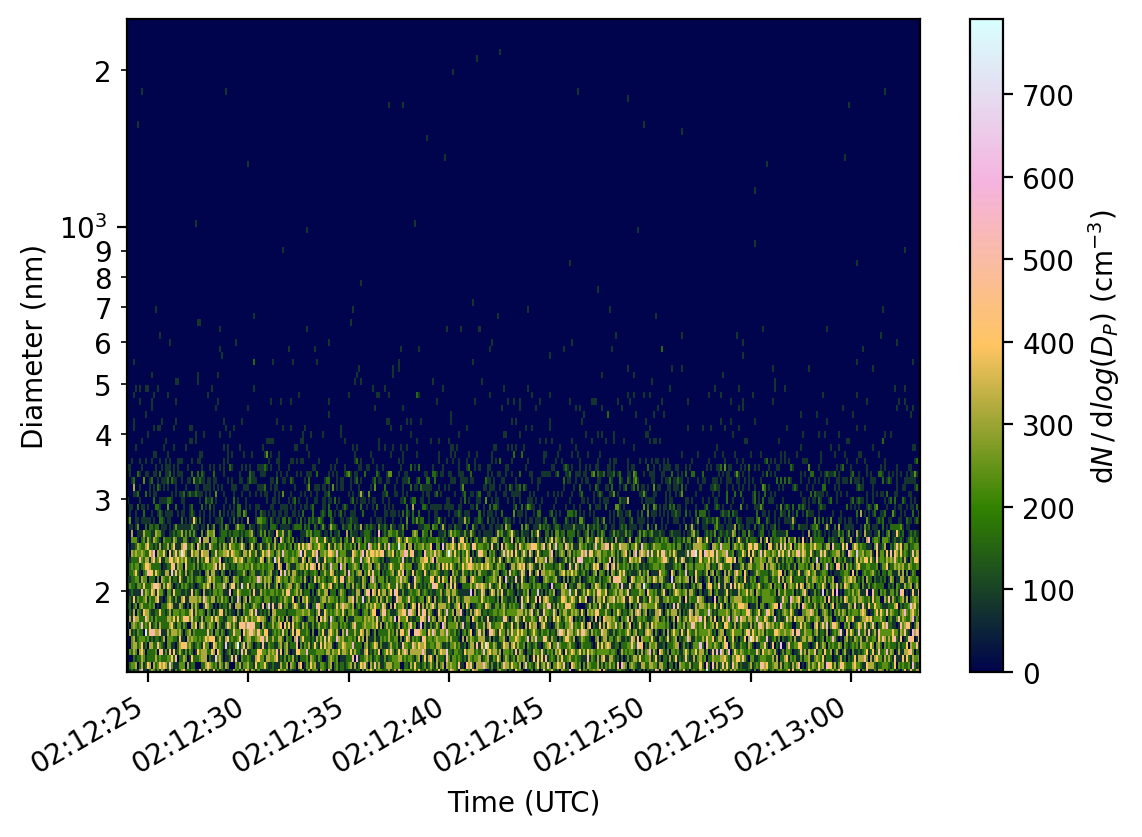

In [12]:
dist.plot()

# outside range particles

The function above also records all particles that are outside the calibration range.

<Axes: >

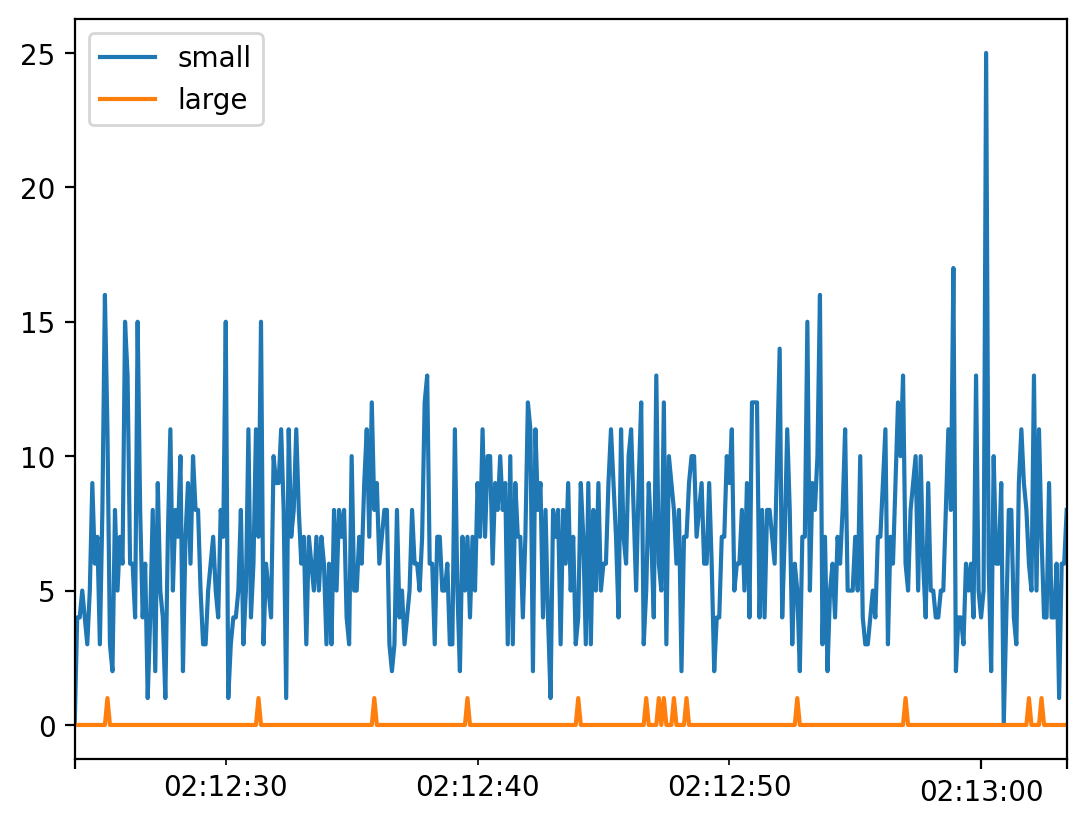

In [13]:
dist.particle_number_concentration_outside_range.plot()

# normalize to flow rate

You probably want to normalize the particle rates to particle concentrations by dividing by the flow rate. It is important not to apply operations solely to the data container. Instead perform the opperation on the entire sizedistribution instance. 

In [15]:
dist /= 3

<Axes: >

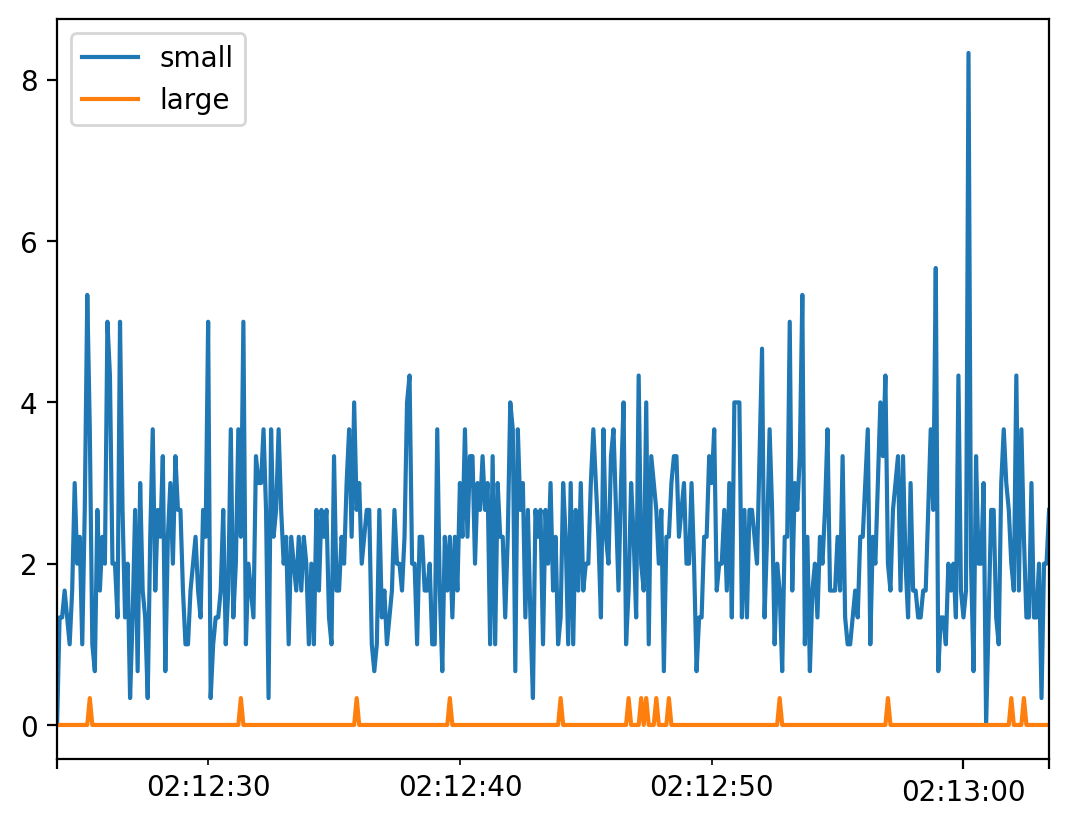

In [16]:
dist.particle_number_concentration_outside_range.plot()

# Save Sizedistribution

In [17]:
dist.save_netcdf('~/tmp/test.nc')

In [18]:
ds = xr.open_dataset('~/tmp/test.nc')

In [19]:
ds

<xarray.Dataset> Size: 318kB
Dimensions:           (idx: 100, Time: 395, bincenters: 99)
Coordinates:
  * idx               (idx) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * Time              (Time) datetime64[ns] 3kB 2022-09-21T02:12:24 ... 2022-...
  * bincenters        (bincenters) float64 792B 142.1 146.3 ... 2.464e+03
Data variables:
    binedges          (idx) float64 800B ...
    sizedistribution  (Time, bincenters) float64 313kB ...
Attributes:
    type:                 SizeDist_TS
    data_period:          None
    info:                 Aerosol size distribution data generated with atmPy...
    tags:                 
    applied_corrections: